## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import pickle

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import RandomizedSearchCV

np.set_printoptions(suppress=True) # Suppress scientific notation where possible

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

from mlxtend.plotting import plot_decision_regions
%matplotlib inline

# make prettier plots
%config InlineBackend.figure_format = 'svg' 

In [2]:
# to open pickled data

with open("MVP_patientlevel_intubation.pkl", 'rb') as picklefile: 
    patients = pickle.load(picklefile)

patients.head()

,id,Age,Patient_Gender,Pneumonia,Pregnant,Indigenous,Diabetic,COPD_Lung_Disease,Asthma,Immunosuppressed,Hypertension,Comorbidity,Cardiovascular_Disease,Obese,Chronic_Renal_Insufficiency,Intensive_Care,Intubation
0,35483,50,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7062,25,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,13779,29,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,17334,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2789,64,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0


In [3]:
patients.shape

(98820, 17)

## 2. Improve balance using random oversampling of the minority class

In [9]:
ros = RandomOverSampler(random_state=0)
X = patients.iloc[:, 1:-1]
y = patients['Intubation']
X_resampled, y_resampled = ros.fit_sample(X, y)

In [10]:
# confirm target class is now balanced

Counter(y_resampled)

Counter({0: 96726, 1: 96726})

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, \
                                                            test_size=0.3, random_state=42)

In [12]:
scaler = MinMaxScaler()
X_train["Age"] = scaler.fit_transform(X_train["Age"].values.astype(float).reshape(-1,1))

<ipython-input-12-909bd7e59f49>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["Age"] = scaler.fit_transform(X_train["Age"].values.astype(float).reshape(-1,1))


In [13]:
X_test["Age"] = scaler.fit_transform(X_test["Age"].values.astype(float).reshape(-1,1))

<ipython-input-13-96beb5406f99>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["Age"] = scaler.fit_transform(X_test["Age"].values.astype(float).reshape(-1,1))


## 3. Examine model performance after balancing classes

In [14]:
clf_ros = LogisticRegression().fit(X_train, y_train)

In [15]:
y_pred = clf_ros.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {round(accuracy, 4)*100}')

Model Accuracy: 86.89


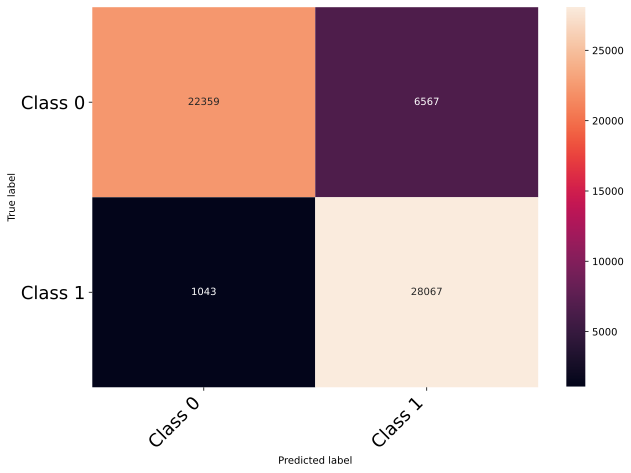

In [18]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm = print_confusion_matrix(conf_mat, ['Class 0', 'Class 1'])

In [19]:
# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, clf_ros.predict_proba(X_test)[:,1])

ROC AUC score =  0.9339302883133743


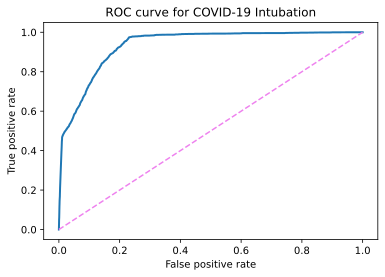

In [20]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for COVID-19 Intubation');
print("ROC AUC score = ", roc_auc_score(y_test, clf_ros.predict_proba(X_test)[:,1]))
plt.savefig("ROC_resampling Logistic Regression")

In [21]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.8806162148594378

In [29]:
from sklearn.metrics import fbeta_score
fbeta_score(y_test, y_pred, beta=0.5)

0.8370912518043974

Now try using smote

In [42]:
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X,y)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_smoted, y_smoted, \
                                                            test_size=0.3, random_state=42)

In [44]:
scaler = MinMaxScaler()
X_train["Age"] = scaler.fit_transform(X_train["Age"].values.astype(float).reshape(-1,1))

<ipython-input-44-909bd7e59f49>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["Age"] = scaler.fit_transform(X_train["Age"].values.astype(float).reshape(-1,1))


In [45]:
scaler = MinMaxScaler()
X_test["Age"] = scaler.fit_transform(X_test["Age"].values.astype(float).reshape(-1,1))

<ipython-input-45-da80e7a24e32>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["Age"] = scaler.fit_transform(X_test["Age"].values.astype(float).reshape(-1,1))


In [46]:
Counter(y_smoted)

Counter({0: 96726, 1: 96726})

In [52]:
clf_smote = XGBClassifier().fit(X_train, y_train)

/Users/michaeljehl/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:15:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [54]:
print("The score for xgBoost_Smote is")
print("Training: {:6.2f}%".format(100*clf_smote.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*clf_smote.score(X_test, y_test)))

The score for xgBoost_Smote is
Training:  90.30%
Test set:  83.48%


In [55]:
y_pred = clf_smote.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {round(accuracy, 4)*100}')

Model Accuracy: 83.48


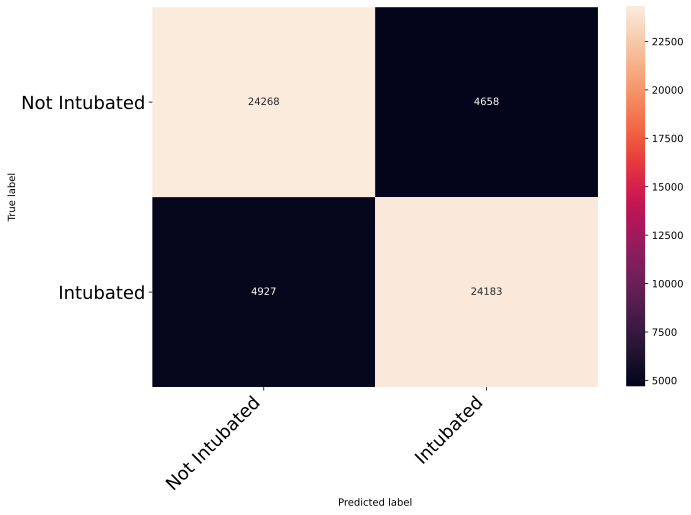

In [56]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm = print_confusion_matrix(conf_mat, ['Not Intubated', 'Intubated'])

In [57]:
from sklearn.metrics import f1_score

f1_score(y_test, y_pred)

0.834601646218357

In [58]:
# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, clf_smote.predict_proba(X_test)[:,1])

ROC AUC score =  0.9071543348521999


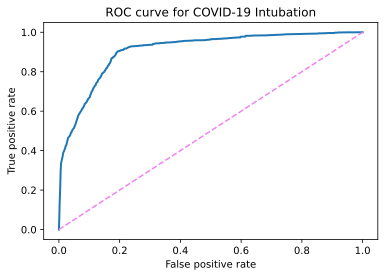

In [59]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for COVID-19 Intubation');
print("ROC AUC score = ", roc_auc_score(y_test, clf_smote.predict_proba(X_test)[:,1]))
plt.savefig("ROC_xgb smote_baseline")